In [1]:
import pandas as pd
import glob
import os
import numpy as np
from pathlib import Path
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Set plot style for the notebook
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# --- CONFIGURATION ---

# 1. Map Traffic Intersections -> Air Quality Stations
# (Based on your "traffic_filter_summary" work)
TRAFFIC_TO_AQ_MAP = {
    'LAWRENCE AVE E / KENNEDY RD': 'Toronto East',
    'STEELES AVE W / DUFFERIN ST': 'Toronto North',
    'FRONT ST W / JOHN ST / PRIVATE ACCESS': 'Toronto Downtown',
    'ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALLENBY AVE': 'Toronto West'
}

# 2. Map Weather Stations -> Air Quality Stations
# (Based on your "meteorological_metadata.yml")
WEATHER_TO_AQ_MAP = {
    'Toronto_City_Centre_Downtown': 'Toronto Downtown',
    'Toronto_City_Ontario_East': 'Toronto East',
    'Toronto_Pearson_Intl_West': 'Toronto West',
    'Toronto_York_North': 'Toronto North'
}

# 3. Standardize Air Quality Station Names
# The raw CSV headers often have IDs like "Toronto East (33003)"
AQ_STATION_NAMES = {
    'Toronto East (33003)': 'Toronto East',
    'Toronto North (34021)': 'Toronto North',
    'Toronto Downtown (31129)': 'Toronto Downtown',
    'Toronto West (35125)': 'Toronto West'
}

# Read in Air Quality Data

In [3]:
# --- CONFIGURATION ---
def get_project_root():
    if '__file__' in globals(): return Path(__file__).resolve().parent.parent
    path = Path.cwd()
    while path.name:
        if (path / 'pyproject.toml').exists(): return path
        path = path.parent
    return Path.cwd()

PROJECT_ROOT = get_project_root()
AQ_DATA_DIR = PROJECT_ROOT / "data" / "air_quality" / "aq_data"

def load_air_quality_raw(folder_path=AQ_DATA_DIR):
    all_data = []
    # Search recursively in case of subfolders
    search_pattern = os.path.join(folder_path, "**", "*.csv")
    files = glob.glob(search_pattern, recursive=True)

    if not files:
        # Fallback to non-recursive if previous failed
        search_pattern = os.path.join(folder_path, "*.csv")
        files = glob.glob(search_pattern)
        
    if not files:
        raise ValueError(f"No files found in {folder_path}")

    print(f"Processing {len(files)} files...")

    for file_path in files:
        # --- STEP A: Extract Metadata ---
        try:
            with open(file_path, 'r', encoding='latin1') as f:
                meta_lines = [next(f) for _ in range(10)]
                # Parse specific lines (Indices may vary slightly by year, but this is standard)
                # Line 2: Name, Line 4: Lat, Line 5: Lon
                station_name = meta_lines[1].split(',')[1].strip()
                lat = meta_lines[3].split(',')[1].strip()
                lon = meta_lines[4].split(',')[1].strip()
        except Exception as e:
            print(f"Skipping {Path(file_path).name}: {e}")
            continue

        # --- STEP B: Load Data ---
        # Note: We do NOT calculate the mean yet. We want to see the raw split rows.
        df = pd.read_csv(file_path, skiprows=10, index_col=False)
        
        # Add Metadata columns
        df['Station'] = station_name
        df['Latitude'] = lat
        df['Longitude'] = lon
        
        all_data.append(df)

    # Combine everything
    df_aq = pd.concat(all_data, ignore_index=True)

    # --- CLEANING ---
    # 1. Replace "Poison" values with NaN
    df_aq.replace([9999, -999, 9999.0, -999.0], np.nan, inplace=True)

    # 2. Date Conversion
    df_aq['Date'] = pd.to_datetime(df_aq['Date'], errors='coerce')
    df_aq = df_aq.dropna(subset=['Date'])
    
    # 3. Sort for inspection
    df_aq = df_aq.sort_values(['Station', 'Date'])

    return df_aq

# --- EXECUTE & INSPECT ---
df_aq_raw = load_air_quality_raw()

df_Toronto_west = df_aq_raw[df_aq_raw["Station"] == 'Toronto West (35125)']

Processing 4 files...


Just Focus on Toronto West 

In [4]:
# Check for duplicate dates specifically in your Toronto West subset
duplicates = df_Toronto_west[df_Toronto_west.duplicated(subset=['Date'], keep=False)]

if not duplicates.empty:
    print(f"found {len(duplicates)} duplicate rows.")
    # Sort by date so duplicate pairs appear next to each other
    # Showing H1 and H20 to help visualize if the data is split between them
    cols_to_view = ['Date', 'Station', 'H1', 'H12', 'H20']
    
    # Only try to show columns that actually exist
    valid_cols = [c for c in cols_to_view if c in duplicates.columns]
    
    print(duplicates.sort_values('Date')[valid_cols])
else:
    print("No duplicate dates found in this dataframe subset.")

found 8 duplicate rows.
           Date               Station   H12   H20
110  2022-04-21  Toronto West (35125)   NaN   NaN
111  2022-04-21  Toronto West (35125)   3.5  12.4
306  2022-11-03  Toronto West (35125)  18.3  30.1
307  2022-11-03  Toronto West (35125)  15.1   9.9
619  2023-09-12  Toronto West (35125)   8.5   NaN
620  2023-09-12  Toronto West (35125)   9.8  15.1
1028 2024-10-25  Toronto West (35125)   NaN   NaN
1029 2024-10-25  Toronto West (35125)   NaN   9.4


In [5]:
# --- MANUAL FIX BY ROW INDEX ---
# Based on your inspection of df_Toronto_west
# We are shifting the SECOND duplicate to the NEXT day (the missing day)

# 1. Ensure we are working on a copy to avoid SettingWithCopy warnings
df_Toronto_west = df_Toronto_west.copy()

print("Applying manual fixes to specific row indices...")

# Fix 1: Duplicate 2022-04-21 -> Shift Row 111 to 2022-04-22
df_Toronto_west.loc[111, 'Date'] = pd.Timestamp('2022-04-22')

# Fix 2: Duplicate 2022-11-03 -> Shift Row 307 to 2022-11-04
df_Toronto_west.loc[307, 'Date'] = pd.Timestamp('2022-11-04')

# Fix 3: Duplicate 2023-09-12 -> Shift Row 620 to 2023-09-13
df_Toronto_west.loc[620, 'Date'] = pd.Timestamp('2023-09-13')

# Fix 4: Duplicate 2024-10-25 -> Shift Row 1029 to 2024-10-26
df_Toronto_west.loc[1029, 'Date'] = pd.Timestamp('2024-10-26')

Applying manual fixes to specific row indices...


In [6]:
# --- CHECK FOR MISSING DATES (GAPS) ---

# 1. Ensure Date is datetime
df_Toronto_west['Date'] = pd.to_datetime(df_Toronto_west['Date'])

# 2. Define the expected full range
start_date = df_Toronto_west['Date'].min()
end_date = df_Toronto_west['Date'].max()
full_range = pd.date_range(start=start_date, end=end_date, freq='D')

# 3. Find the difference
missing_dates = full_range.difference(df_Toronto_west['Date'])

print(f"🔎 Time Series Audit: {start_date.date()} to {end_date.date()}")
print(f"Total Expected Days: {len(full_range)}")
print(f"Actual Days Present: {len(df_Toronto_west)}")
print(f"Missing Days: {len(missing_dates)}")

if len(missing_dates) > 0:
    print("\n⚠️ The following dates are missing:")
    print(missing_dates.strftime('%Y-%m-%d').tolist())
else:
    print("\n✅ No missing dates! The time series is continuous.")

🔎 Time Series Audit: 2022-01-01 to 2024-12-31
Total Expected Days: 1096
Actual Days Present: 1096
Missing Days: 0

✅ No missing dates! The time series is continuous.


Make final data frame for Toronto West. NOTE: WE ARE TAKING THE MEAN WITH THE MISSING VALUES 

In [7]:
# --- FINAL STEP: CALCULATE DAILY MEAN ---
print("Calculating daily averages from hourly data...")

# 1. Identify valid hourly columns (H1, H2... H24)
# We check which ones actually exist in the dataframe to be safe
potential_cols = [f'H{i}' for i in range(1, 25)]
valid_cols = [c for c in potential_cols if c in df_Toronto_west.columns]

# 2. Calculate the Mean (ignoring NaNs)
df_Toronto_west['NO2_Mean'] = df_Toronto_west[valid_cols].mean(axis=1)

# 3. Clean Up: Keep only the essential columns
# We drop the raw hourly columns now to keep the dataframe clean for modeling
cols_to_keep = ['Date', 'Station', 'NO2_Mean', 'Latitude', 'Longitude'] 
# (Add Lat/Lon if they exist, otherwise just Date/Station/NO2)
available_keep = [c for c in cols_to_keep if c in df_Toronto_west.columns]

df_west_final = df_Toronto_west[available_keep].copy()

# Sort by Date just to be sure
df_west_final = df_west_final.sort_values('Date').reset_index(drop=True)

print(f"✅ Toronto West AQ Ready: {df_west_final.shape}")
print(df_west_final.head())

Calculating daily averages from hourly data...
✅ Toronto West AQ Ready: (1096, 5)
        Date               Station   NO2_Mean   Latitude Longitude
0 2022-01-01  Toronto West (35125)   5.400000  43.709444  -79.5435
1 2022-01-02  Toronto West (35125)   7.120000  43.709444  -79.5435
2 2022-01-03  Toronto West (35125)  15.940000  43.709444  -79.5435
3 2022-01-04  Toronto West (35125)  16.346667  43.709444  -79.5435
4 2022-01-05  Toronto West (35125)   9.586667  43.709444  -79.5435


# Get Traffic Data

In [8]:
PROJECT_ROOT = get_project_root()
TRAFFIC_PATH = PROJECT_ROOT / "data" / "traffic" / "filtered_roads_with_sums.csv"
traffic_df = pd.read_csv(TRAFFIC_PATH)

# Transform traffic data to long format
date_col_pattern = re.compile(r"^x\d{4}_\d{2}_\d{2}$")
traffic_date_cols = [c for c in traffic_df.columns if date_col_pattern.match(str(c))]

traffic_long = []
for idx, row in traffic_df.iterrows():
    camera_road = row['camera_road']
    for col in traffic_date_cols:
        traffic_value = row[col]
        if pd.notna(traffic_value):
            date_str = col[1:]
            date = pd.to_datetime(date_str, format='%Y_%m_%d')
            traffic_long.append({
                'Date': date,
                'camera_road': camera_road,
                'traffic_count': traffic_value
            })

traffic_long_df = pd.DataFrame(traffic_long)
print(f"\nTraffic data loaded: {len(traffic_long_df)} records")
print(f"Date range: {traffic_long_df['Date'].min()} to {traffic_long_df['Date'].max()}")
print(f"\nLocations: {traffic_long_df['camera_road'].unique()}")

# Create location mapping
location_mapping = {
    'LAWRENCE AVE E / KENNEDY RD': 'Toronto East',
    'STEELES AVE W / DUFFERIN ST': 'Toronto North',
    'FRONT ST W / JOHN ST / PRIVATE ACCESS': 'Toronto Downtown',
    'ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALLENBY AVE': 'Toronto West'
}

# Add station names to traffic data
traffic_long_df['Station'] = traffic_long_df['camera_road'].map(location_mapping)

print("Location Mapping:")
for traffic_loc, aq_station in location_mapping.items():
    print(f"  {aq_station}: {traffic_loc}")
    
df_traffic_Toronto_west = traffic_long_df[traffic_long_df['Station']=='Toronto West']


Traffic data loaded: 4300 records
Date range: 2022-02-03 00:00:00 to 2025-10-31 00:00:00

Locations: <StringArray>
[                 'FRONT ST W / JOHN ST / PRIVATE ACCESS',
                            'STEELES AVE W / DUFFERIN ST',
 'ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALLENBY AVE',
                            'LAWRENCE AVE E / KENNEDY RD']
Length: 4, dtype: str
Location Mapping:
  Toronto East: LAWRENCE AVE E / KENNEDY RD
  Toronto North: STEELES AVE W / DUFFERIN ST
  Toronto Downtown: FRONT ST W / JOHN ST / PRIVATE ACCESS
  Toronto West: ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALLENBY AVE


Check for missing data in Toronto West

In [9]:
# --- AUDIT MISSING TRAFFIC DATES (Toronto West) ---

# 1. Ensure Date is datetime
df_traffic_Toronto_west = df_traffic_Toronto_west.copy()
df_traffic_Toronto_west['Date'] = pd.to_datetime(df_traffic_Toronto_west['Date'])

# 2. Define the expected full range based on the data's own limits
start_date = df_traffic_Toronto_west['Date'].min()
end_date = df_traffic_Toronto_west['Date'].max()
full_range = pd.date_range(start=start_date, end=end_date, freq='D')

# 3. Find the difference
missing_dates = full_range.difference(df_traffic_Toronto_west['Date'])

print(f"🔎 Traffic Data Audit (Toronto West)")
print(f"   Range: {start_date.date()} to {end_date.date()}")
print(f"   Total Expected Days: {len(full_range)}")
print(f"   Actual Days Present: {len(df_traffic_Toronto_west)}")
print(f"   Missing Days: {len(missing_dates)}")

if len(missing_dates) > 0:
    print("\n⚠️ Sample of missing dates:")
    # Print first 5 and last 5 to see where gaps are
    print(missing_dates[:5].strftime('%Y-%m-%d').tolist())
    if len(missing_dates) > 5:
        print("...")
        print(missing_dates[-5:].strftime('%Y-%m-%d').tolist())
else:
    print("\n✅ No missing dates! Traffic data is continuous.")

🔎 Traffic Data Audit (Toronto West)
   Range: 2022-02-03 to 2025-10-31
   Total Expected Days: 1367
   Actual Days Present: 1144
   Missing Days: 223

⚠️ Sample of missing dates:
['2022-11-01', '2022-11-02', '2022-11-03', '2022-11-04', '2022-11-05']
...
['2025-09-28', '2025-09-29', '2025-09-30', '2025-10-01', '2025-10-02']


Merging Toronto West Data...
✅ Merged Dataset Shape: (900, 3)
   (Dropped 196 days from AQ that had no Traffic data)

📊 Correlation (Traffic vs NO2): nan
   P-Value: nan (Significant if < 0.05)


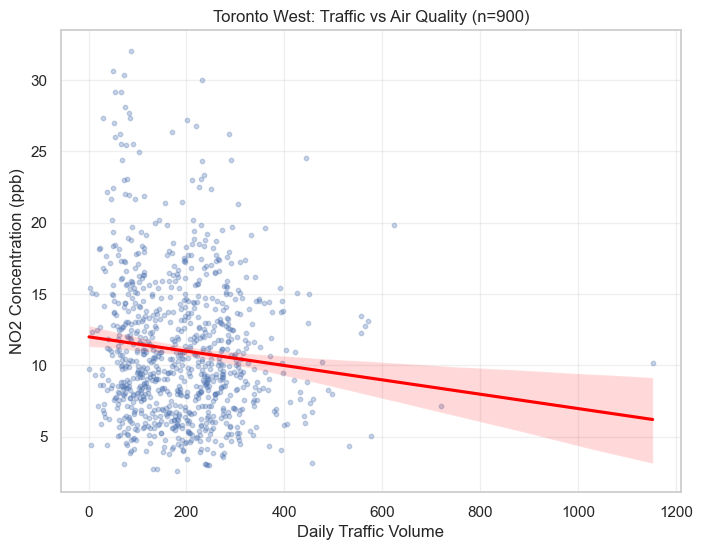

In [10]:
from scipy.stats import pearsonr
# --- 1. MERGE (Inner Join) ---
# We merge on 'Date'. 'Station' is redundant since we know both are Toronto West, 
# but good practice to include if columns exist.
print("Merging Toronto West Data...")

df_merged = pd.merge(
    df_Toronto_west[['Date', 'NO2_Mean']], 
    df_traffic_Toronto_west[['Date', 'traffic_count']], 
    on='Date', 
    how='inner'
)

print(f"✅ Merged Dataset Shape: {df_merged.shape}")
print(f"   (Dropped {len(df_west_final) - len(df_merged)} days from AQ that had no Traffic data)")

# --- 2. QUICK CORRELATION CHECK ---
corr, p_value = pearsonr(df_merged['traffic_count'], df_merged['NO2_Mean'])

print(f"\n📊 Correlation (Traffic vs NO2): {corr:.4f}")
print(f"   P-Value: {p_value:.4e} (Significant if < 0.05)")

# --- 3. VISUALIZE ---
plt.figure(figsize=(8, 6))
sns.regplot(data=df_merged, x='traffic_count', y='NO2_Mean', 
            scatter_kws={'alpha':0.3, 's':10}, line_kws={'color':'red'})

plt.title(f"Toronto West: Traffic vs Air Quality (n={len(df_merged)})")
plt.xlabel("Daily Traffic Volume")
plt.ylabel("NO2 Concentration (ppb)")
plt.grid(True, alpha=0.3)
plt.show()

In [19]:
df_merged.shape

(900, 3)

Get Wetehr Data from Toronto West and fill forward impute for missingnes 

In [11]:
# --- CONFIGURATION ---
WEATHER_DATA_DIR = PROJECT_ROOT / "data" / "weather" / "weather_data"

# Added 'Spd of Max Gust (km/h)' back in
WEATHER_COLS_TO_KEEP = {
    'Date/Time': 'Date',
    'Mean Temp (°C)': 'Mean_Temp',
    'Min Temp (°C)': 'Min_Temp',
    'Max Temp (°C)': 'Max_Temp',
    'Total Precip (mm)': 'Total_Precip',
    'Spd of Max Gust (km/h)': 'Max_Gust_Spd'
}

def load_weather_data(folder_path=WEATHER_DATA_DIR):
    all_weather = []
    search_pattern = os.path.join(folder_path, "*.csv")
    files = glob.glob(search_pattern)
    
    print(f"Processing {len(files)} weather files...")

    # 1. Load all raw data
    for file_path in files:
        df = pd.read_csv(file_path)
        filename = Path(file_path).stem 
        
        if filename in WEATHER_TO_AQ_MAP:
            target_station_name = WEATHER_TO_AQ_MAP[filename]
        else:
            continue

        # Rename columns
        df = df.rename(columns=WEATHER_COLS_TO_KEEP)
        cols_to_select = [c for c in WEATHER_COLS_TO_KEEP.values() if c in df.columns]
        df = df[cols_to_select].copy()
        
        df['Station'] = target_station_name
        all_weather.append(df)

    df_weather = pd.concat(all_weather, ignore_index=True)
    df_weather['Date'] = pd.to_datetime(df_weather['Date'])
    
    # --- STEP 2: Handle Temperature & Precip (Station-Specific LOCF) ---
    # Sort for correct time-based filling
    df_weather = df_weather.sort_values(by=['Station', 'Date'])
    
    cols_local = ['Mean_Temp', 'Min_Temp', 'Max_Temp', 'Total_Precip']
    print("Imputing local vars (Temp, Precip) with LOCF...")
    for col in cols_local:
        if col in df_weather.columns:
            df_weather[col] = df_weather.groupby('Station')[col].ffill()

    # --- STEP 3: Handle Wind (Regional Proxy from Toronto West) ---
    print("Processing Regional Wind Data (Proxy: Toronto West)...")
    
    # A. Extract only Toronto West data (Pearson is usually the most reliable)
    # We assume 'Toronto West' is the name in your WEATHER_TO_AQ_MAP
    wind_proxy = df_weather[df_weather['Station'] == 'Toronto West'][['Date', 'Max_Gust_Spd']].copy()
    
    # B. Sort and LOCF the wind data specifically
    wind_proxy = wind_proxy.sort_values('Date')
    wind_proxy['Max_Gust_Spd'] = wind_proxy['Max_Gust_Spd'].ffill()
    
    # C. Drop the original (gappy) wind column from the main dataset
    if 'Max_Gust_Spd' in df_weather.columns:
        df_weather = df_weather.drop(columns=['Max_Gust_Spd'])
        
    # D. Merge the filled "Regional Wind" back to ALL stations based on Date
    # This effectively copies Toronto West wind to East, North, and Downtown
    df_weather = pd.merge(df_weather, wind_proxy, on='Date', how='left')
    
    # Fill remaining NaNs (if Toronto West started later than other stations) with 0 or mean
    df_weather['Max_Gust_Spd'] = df_weather['Max_Gust_Spd'].fillna(0)

    print(f"✅ Weather Data Loaded & Imputed: {len(df_weather)} rows")
    return df_weather

# --- EXECUTE ---
df_weather = load_weather_data()
df_weather.head()

df_weather_toronto = df_weather[df_weather['Station']=="Toronto West"]

Processing 4 weather files...
Imputing local vars (Temp, Precip) with LOCF...
Processing Regional Wind Data (Proxy: Toronto West)...
✅ Weather Data Loaded & Imputed: 5844 rows


In [12]:
# --- AUDIT MISSING WEATHER DATES (Toronto West) ---

# 1. Ensure copy to avoid warnings
df_weather_audit = df_weather_toronto.copy()
df_weather_audit['Date'] = pd.to_datetime(df_weather_audit['Date'])

# 2. Check for Duplicates first (Common in weather data merges)
dupes = df_weather_audit[df_weather_audit.duplicated(subset=['Date'], keep=False)]
if not dupes.empty:
    print(f"⚠️ Warning: Found {len(dupes)} duplicate dates. We should handle these before checking gaps.")
else:
    print("✅ No duplicate dates found.")

# 3. Define Expected Range
start_date = df_weather_audit['Date'].min()
end_date = df_weather_audit['Date'].max()
full_range = pd.date_range(start=start_date, end=end_date, freq='D')

# 4. Find Missing Days
missing_dates = full_range.difference(df_weather_audit['Date'])

print(f"\n🔎 Weather Data Audit (Toronto West)")
print(f"   Range: {start_date.date()} to {end_date.date()}")
print(f"   Total Expected Days: {len(full_range)}")
print(f"   Actual Days Present: {len(df_weather_audit)}")
print(f"   Missing Days: {len(missing_dates)}")

if len(missing_dates) > 0:
    print("\n⚠️ Sample of missing dates:")
    print(missing_dates[:5].strftime('%Y-%m-%d').tolist())
    if len(missing_dates) > 5:
        print("...")
        print(missing_dates[-5:].strftime('%Y-%m-%d').tolist())
else:
    print("\n✅ No missing dates! Weather data is continuous.")

✅ No duplicate dates found.

🔎 Weather Data Audit (Toronto West)
   Range: 2022-01-01 to 2025-12-31
   Total Expected Days: 1461
   Actual Days Present: 1461
   Missing Days: 0

✅ No missing dates! Weather data is continuous.


# Model Checking

While the other varaibles such as weather and No2 mean can have missing values fillled with some simple imputation, traffic has weeks of missing data that we need to consider. One option is to use a model that just handles the missing values, the other is to use some more sophiscatsed imputation perhaps. 

✅ Master Data Shape: (1065, 5)

📊 PREDICTOR AUDIT: Where are the holes?
NO2_Mean          0.563380
traffic_count    15.492958
Mean_Temp         0.000000
Max_Gust_Spd      0.000000
Total_Precip      0.000000
dtype: float64


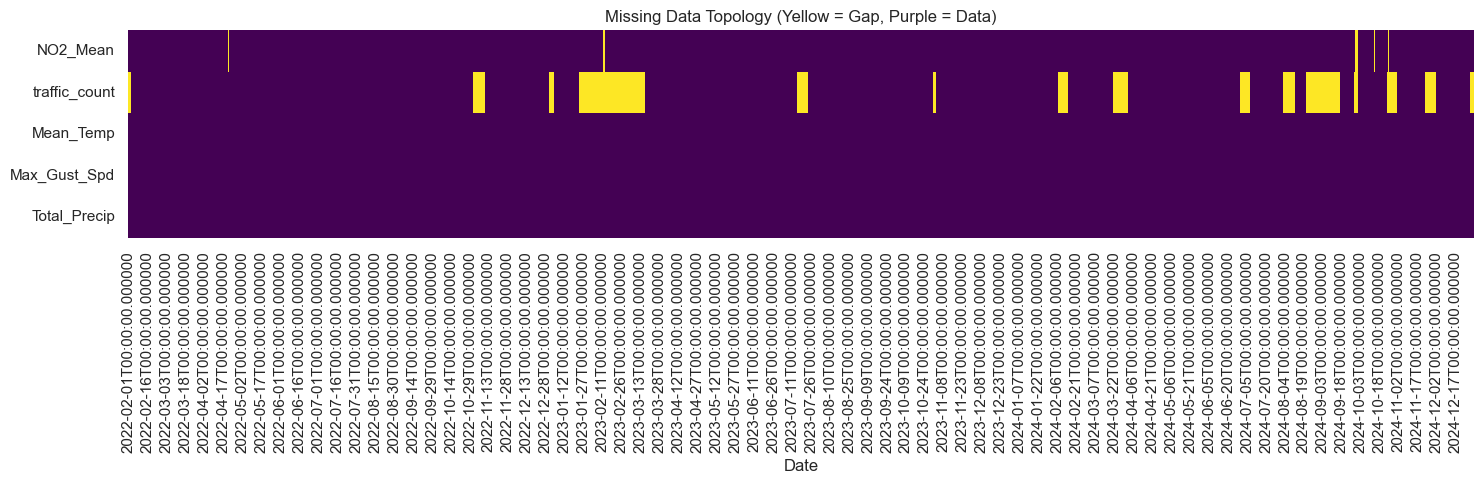

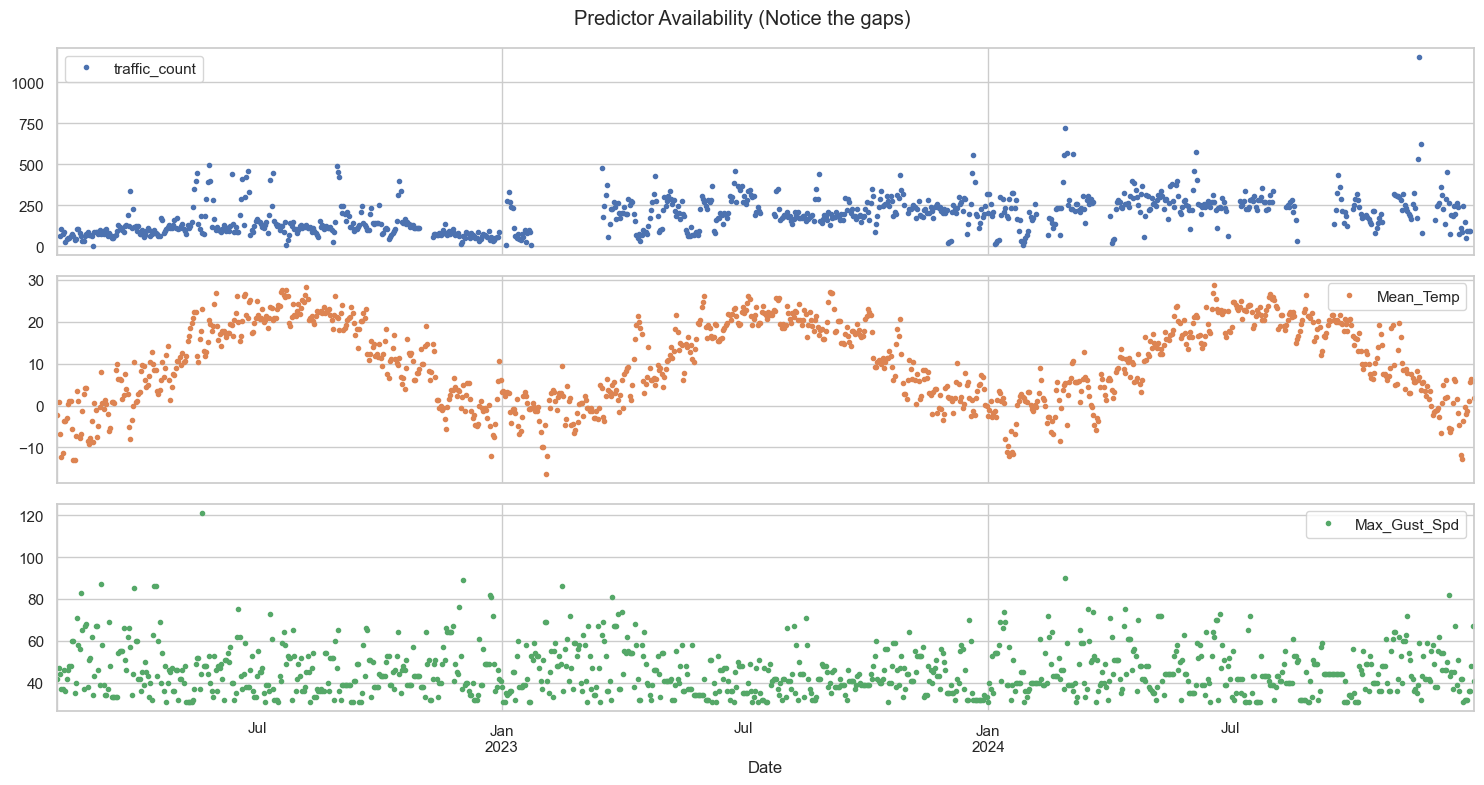

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# --- 1. SETUP DATA (Same as before) ---
# Ensure df_master is created with gaps preserved
# (Assuming df_west_final, df_traffic_Toronto_west, df_weather_toronto are loaded)

df_master = pd.merge(
    df_west_final[['Date', 'NO2_Mean']], 
    df_traffic_Toronto_west[['Date', 'traffic_count']], 
    on='Date', how='outer'
)
df_master = pd.merge(
    df_master,
    df_weather_toronto[['Date', 'Mean_Temp', 'Max_Gust_Spd', 'Total_Precip']],
    on='Date', how='outer'
)

df_master['Date'] = pd.to_datetime(df_master['Date'])
df_master = df_master.sort_values('Date').set_index('Date')
df_master = df_master['2022-02-01':'2024-12-31'] 

print(f"✅ Master Data Shape: {df_master.shape}")


# --- 2. AUDIT: VISUALIZE PREDICTOR GAPS ---
print("\n📊 PREDICTOR AUDIT: Where are the holes?")

# Calculate % missing per column
missing_stats = df_master.isnull().mean() * 100
print(missing_stats)

# Plot 1: Heatmap of Missingness
plt.figure(figsize=(15, 5))
sns.heatmap(df_master.isnull().T, cbar=False, cmap='viridis')
plt.title("Missing Data Topology (Yellow = Gap, Purple = Data)")
plt.tight_layout()
plt.show()

# Plot 2: Time Series of Predictors (Visualizing the Gaps)
cols_to_plot = ['traffic_count', 'Mean_Temp', 'Max_Gust_Spd']
df_master[cols_to_plot].plot(subplots=True, figsize=(15, 8), title="Predictor Availability (Notice the gaps)", marker='.', linestyle='none')
plt.tight_layout()
plt.show()


Should we include or not inclue the time variables 


⚔️ TOURNAMENT: Does Traffic Add Value?

🏆 FINAL RESULTS (RMSE)
Baseline (Weather Only):  3.9150
Challenger (With Traffic): 3.8771

✅ RESULT: Traffic Signal Detected! (Error reduced by 0.0379)
   Interpretation: Even with the missing days, the traffic data provides
   unique information that weather alone cannot explain.


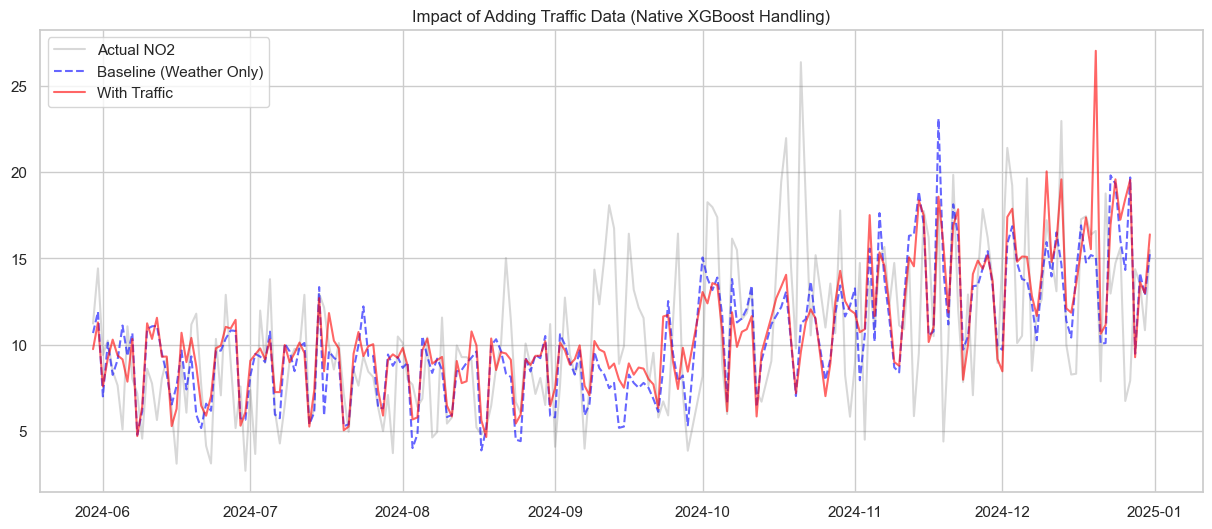

In [17]:
# --- 2. DEFINE THE TWO COMPETITORS ---

# Feature Engineering
df_model = df_master.copy()
df_model['Is_Weekend'] = (df_model.index.dayofweek >= 5).astype(int)
df_model['Month'] = df_model.index.month

# Drop rows where we don't know the answer (Missing NO2)
df_model = df_model.dropna(subset=['NO2_Mean'])

# Split Train/Test (80/20)
train_size = int(len(df_model) * 0.8)
train = df_model.iloc[:train_size]
test = df_model.iloc[train_size:]

# --- DEFINING THE PREDICTOR SETS ---
# Model A: The Skeptic (Believes only Weather & Time matter)
predictors_no_traffic = ['Mean_Temp', 'Max_Gust_Spd', 'Total_Precip', 'Month', 'Is_Weekend']

# Model B: The Believer (Adds Traffic to the Skeptic's list)
predictors_with_traffic =  ['traffic_count'] + ['Mean_Temp', 'Max_Gust_Spd', 'Total_Precip', 'Month', 'Is_Weekend']

target = 'NO2_Mean'


# --- 3. RUN THE TOURNAMENT ---
print("\n⚔️ TOURNAMENT: Does Traffic Add Value?")

# MODEL A: NO TRAFFIC
model_a = XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
model_a.fit(train[predictors_no_traffic], train[target])
pred_a = model_a.predict(test[predictors_no_traffic])
rmse_a = np.sqrt(mean_squared_error(test[target], pred_a))

# MODEL B: WITH TRAFFIC (Native Handling of Gaps)
model_b = XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
model_b.fit(train[predictors_with_traffic], train[target])
pred_b = model_b.predict(test[predictors_with_traffic])
rmse_b = np.sqrt(mean_squared_error(test[target], pred_b))


# --- 4. THE VERDICT ---
print("\n" + "="*40)
print(f"🏆 FINAL RESULTS (RMSE)")
print("="*40)
print(f"Baseline (Weather Only):  {rmse_a:.4f}")
print(f"Challenger (With Traffic): {rmse_b:.4f}")

improvement = rmse_a - rmse_b
if improvement > 0:
    print(f"\n✅ RESULT: Traffic Signal Detected! (Error reduced by {improvement:.4f})")
    print("   Interpretation: Even with the missing days, the traffic data provides")
    print("   unique information that weather alone cannot explain.")
else:
    print(f"\n⚠️ RESULT: Traffic Added Noise (Error increased by {abs(improvement):.4f})")
    print("   Interpretation: The gaps are too frequent, or traffic is too stable")
    print("   to add value beyond what 'Is_Weekend' already tells us.")

# Plot
plt.figure(figsize=(15, 6))
plt.plot(test.index, test[target], label='Actual NO2', color='gray', alpha=0.3)
plt.plot(test.index, pred_a, label='Baseline (Weather Only)', color='blue', alpha=0.6, linestyle='--')
plt.plot(test.index, pred_b, label='With Traffic', color='red', alpha=0.6)
plt.title("Impact of Adding Traffic Data (Native XGBoost Handling)")
plt.legend()
plt.show()

📊 Baseline RMSE: 4.1509
------------------------------
Feature: traffic_count   | Shuffled RMSE: 4.2536 | Impact: +0.1027
Feature: Mean_Temp       | Shuffled RMSE: 4.5795 | Impact: +0.4286


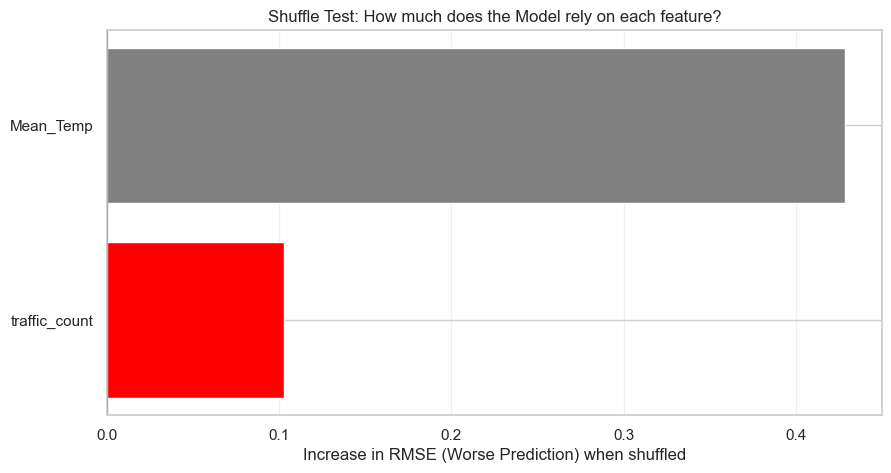

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

# --- CONFIGURATION ---
# We use the model and data from the previous step
model_to_test = model_b  # The XGBoost model WITH traffic
test_set = test.copy()   # The Test set (20% holdout)
features_to_test = ['traffic_count', 'Mean_Temp']
n_repeats = 10           # Shuffle 10 times to get a stable average

# 1. Calculate Baseline Performance (The "Real" Score)
baseline_pred = model_to_test.predict(test_set[predictors_with_traffic])
baseline_rmse = np.sqrt(mean_squared_error(test_set[target], baseline_pred))

print(f"📊 Baseline RMSE: {baseline_rmse:.4f}")
print("-" * 30)

results = []

# 2. Run the Shuffle Test
for feature in features_to_test:
    scores = []
    
    for i in range(n_repeats):
        # A. Create a copy of the test set
        X_shuffled = test_set[predictors_with_traffic].copy()
        
        # B. SHUFFLE the specific column (Break the link to reality)
        # We sample with replacement or just shuffle in place
        X_shuffled[feature] = np.random.permutation(X_shuffled[feature].values)
        
        # C. Predict again with the broken data
        shuffled_pred = model_to_test.predict(X_shuffled)
        shuffled_rmse = np.sqrt(mean_squared_error(test_set[target], shuffled_pred))
        
        scores.append(shuffled_rmse)
    
    # Average the damage done
    avg_shuffled_rmse = np.mean(scores)
    # How much worse did it get? (Positive = Important)
    drop_in_performance = avg_shuffled_rmse - baseline_rmse
    
    print(f"Feature: {feature:15} | Shuffled RMSE: {avg_shuffled_rmse:.4f} | Impact: +{drop_in_performance:.4f}")
    
    results.append({
        'Feature': feature,
        'Impact': drop_in_performance
    })

# --- 3. VISUALIZE THE IMPACT ---
df_impact = pd.DataFrame(results).sort_values('Impact', ascending=True)

plt.figure(figsize=(10, 5))
# Color logic: Red for Traffic, Gray for others
colors = ['red' if x == 'traffic_count' else 'gray' for x in df_impact['Feature']]

plt.barh(df_impact['Feature'], df_impact['Impact'], color=colors)
plt.title("Shuffle Test: How much does the Model rely on each feature?")
plt.xlabel("Increase in RMSE (Worse Prediction) when shuffled")
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.show()

In [18]:
df_master.shape

(1065, 5)

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# --- 1. PREPARE THE DATA ---
df_reg = df_master.dropna(subset=['traffic_count', 'NO2_Mean', 'Mean_Temp', 'Max_Gust_Spd']).copy()

# A. Create the Non-Linear Term
# We scale it down by 1,000,000 to keep the coefficients readable 
# (otherwise the number will be like 0.000000001)
df_reg['traffic_sq'] = (df_reg['traffic_count'] ** 2) 

# B. Add Controls
df_reg['Month'] = df_reg.index.month

# --- 2. DEFINE THE VARIABLES ---
# We include BOTH the linear part and the squared part
features = ['traffic_count', 'traffic_sq', 'Mean_Temp',  'Total_Precip']
target = 'NO2_Mean'

X = df_reg[features]
y = df_reg[target]

# Add Intercept
X = sm.add_constant(X)

# --- 3. RUN THE REGRESSION ---
print("📊 RUNNING QUADRATIC REGRESSION...")
model = sm.OLS(y, X).fit()

# --- 4. PRINT REPORT ---
print(model.summary())

# --- 5. INTERPRETATION ---
coef_lin = model.params['traffic_count']
coef_sq = model.params['traffic_sq']
p_lin = model.pvalues['traffic_count']
p_sq = model.pvalues['traffic_sq']

print("\n" + "="*40)
print(f"🚦 NON-LINEAR VERDICT")
print("="*40)
print(f"Linear Term:  {coef_lin:.6f} (P={p_lin:.4f})")
print(f"Squared Term: {coef_sq:.9f} (P={p_sq:.4f})")

if p_sq < 0.05:
    print("\n✅ SIGNIFICANT CURVE DETECTED!")
    if coef_sq > 0:
        print("   Shape: CONVEX (Exponential).")
        print("   Interpretation: Pollution gets WORSE at a faster rate as traffic grows.")
        print("   (Likely Cause: Congestion/Idling effects at high volume).")
    else:
        print("   Shape: CONCAVE (Diminishing Returns).")
        print("   Interpretation: Pollution levels off at high traffic.")
else:
    print("\n❌ NO CURVE DETECTED.")
    print("   The relationship is effectively linear. The squared term added no value.")

📊 RUNNING QUADRATIC REGRESSION...
                            OLS Regression Results                            
Dep. Variable:               NO2_Mean   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     38.77
Date:                Tue, 03 Feb 2026   Prob (F-statistic):           5.94e-30
Time:                        17:47:23   Log-Likelihood:                -2654.7
No. Observations:                 898   AIC:                             5319.
Df Residuals:                     893   BIC:                             5343.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const       